# iPRules

# Statics

In [41]:
import dask.dataframe as dd
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import metrics


## Load Dataset

In [42]:

from notebooks.IPRules.read_datasets import read_dataset
dataset_names = [
    "divorce",
    "kr-vs-kp",
    "australian",
    "criotherapy",
    "data_banknote_authentication",
    "haberman",
    "mammographic_masses",
    "segmentation",
    "tic-tac-toe",
    "wisconsin",
    "salud-covid",
    "SPECT",
    "ionosphere",
    "connect-4",
    "credit"
]
filename = "connect-4"
#filename = "divorce"
test_size=0.1
path = f'../..'
dataset_path_name = f'{path}/data/{filename}.csv'
X, y, dataset, target_value_name, pandas_dataset = read_dataset(filename, dataset_path_name)

pandas_dataset.head()

,F1_b,F1_o,F1_x,F2_b,F2_o,F2_x,F3_b,F3_o,F3_x,F4_b,...,F40_b,F40_o,F40_x,F41_b,F41_o,F41_x,F42_b,F42_o,F42_x,Class
0,True,False,False,True,False,False,True,False,False,True,...,True,False,False,True,False,False,True,False,False,True
1,True,False,False,True,False,False,True,False,False,True,...,True,False,False,True,False,False,True,False,False,True
2,True,False,False,True,False,False,True,False,False,True,...,True,False,False,True,False,False,True,False,False,True
3,True,False,False,True,False,False,True,False,False,True,...,True,False,False,True,False,False,True,False,False,True
4,False,True,False,True,False,False,True,False,False,True,...,True,False,False,True,False,False,True,False,False,True


In [43]:
#Define dataset
X_train, X_test, y_train, y_test = train_test_split(dataset.data, dataset.target, test_size=test_size, random_state=1)
encoded_train_pandas_dataset = pd.DataFrame(data= np.c_[X_train, y_train], columns= list(dataset['feature_names']) + [target_value_name])
encoded_test_pandas_dataset = pd.DataFrame(data= np.c_[X_test, y_test], columns= list(dataset['feature_names']) + [target_value_name])
print('Sizes (without target):')
print(f'Original size {dataset.data.shape}')
print(f'Train size {X_train.shape}')
print(f'Test size {X_test.shape}')
print(f'encoded_train_pandas_dataset size {encoded_train_pandas_dataset.shape}')
print(f'encoded_test_pandas_dataset size {encoded_test_pandas_dataset.shape}')

Sizes (without target):
Original size (67557, 126)
Train size (60801, 126)
Test size (6756, 126)
encoded_train_pandas_dataset size (60801, 127)
encoded_test_pandas_dataset size (6756, 127)


## Define Random Forest

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, make_scorer, recall_score, accuracy_score

# Define scorer
ensemble = RandomForestClassifier(n_estimators=100, criterion="gini")
ensemble.fit(X_train, y_train)

RandomForestClassifier()

## iPRules

->Extract feature importance list


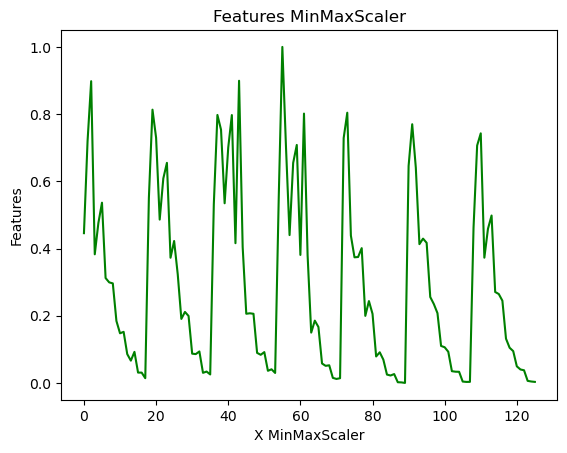

	 Original features 126
	 Selected features 117
	 Percentage of selected rules: 92.85714285714286 %
->Generate new tree based on list


In [ ]:
from iPRules.iPRules import iPRules

import time
start_time = time.time()
rules = iPRules(
                feature_names=dataset.feature_names,
                target_value_name = dataset.target_names,
                display_features = True,
                display_logs = True,
                chi_square_percent_point_function = 0.99,
                scale_feature_coefficient = 0.01,
                min_accuracy_coefficient = 0.9,
                min_number_class_per_node = 3
            )
# Fit model
rules.fit(encoded_train_pandas_dataset, ensemble.feature_importances_)

elapsed_time = time.time() - start_time
print(f"Elapsed TOTAL TIME: {elapsed_time:.3f} seconds")

# Print Model

In [ ]:
print(rules)

# Predict

In [ ]:
# ENSEMBLE
y_pred_test_ensemble = ensemble.predict(X_test)

# RULES
y_pred_test_rules = rules.predict(X_test, sorting_method="target_accuracy")

In [ ]:
# CATEGORIZABLES
np_array_rules = np.array(y_pred_test_rules)
#not_filter_indices = np.where(np.logical_and(np_array_rules != 0, np_array_rules!=1))[0]
filter_indices = np.where(np_array_rules != None)[0]


np_filterred_y_test = np.array(y_test)[filter_indices]
np_filterred_y_pred_test_ensemble = np.array(y_pred_test_ensemble)[filter_indices]
np_filterred_y_pred_test_rules = np.array(y_pred_test_rules)[filter_indices]
# CHANGE FORMAT IN ORDER TO NOT HAVE PROBLEMS
np_filterred_y_pred_test_rules = np_filterred_y_pred_test_rules.astype('int64')


print(f'DATASET TEST: {len(y_test)}')
print(f'DATASET TEST categorizable: {len(np_filterred_y_test)}')
print('Cobertura:',str("{:.2f}".format(100*(len(np_filterred_y_pred_test_rules)/len(y_test))))+'%')

ensemble_accuracy = metrics.accuracy_score(np_filterred_y_test, np_filterred_y_pred_test_ensemble)
print('RF accuracy:',str("{:.2f}".format(100*ensemble_accuracy))+'%')
ensemble_accuracy = metrics.f1_score(np_filterred_y_test, np_filterred_y_pred_test_ensemble)
print('RF F1-score:',str("{:.2f}".format(100*ensemble_accuracy))+'%')
rules_accuracy = metrics.accuracy_score(np_filterred_y_test, np_filterred_y_pred_test_rules)
print('Rules Accuracy:',str("{:.2f}".format(100*rules_accuracy))+'%')
rules_accuracy = metrics.f1_score(np_filterred_y_test, np_filterred_y_pred_test_rules)
print('Rules F1-score:',str("{:.2f}".format(100*rules_accuracy))+'%')
rules_accuracy = metrics.roc_auc_score(np_filterred_y_test, np_filterred_y_pred_test_rules)
print('Rules roc_auc_score:',str("{:.2f}".format(100*rules_accuracy))+'%')


# SHAP explainer

In [ ]:
import shap

# Create Tree Explainer object that can calculate shap values
explainer = shap.TreeExplainer(ensemble)

# Evaluate SHAP values
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_train, feature_names=dataset.feature_names)


In [ ]:

shap.summary_plot(shap_values, X_train, feature_names=dataset.feature_names, plot_type="dot")